## Create a list containing the GAIA IDs of the objects within a given radius from a sky position

Documentation:

https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products

In [2]:
from astroquery.gaia import GaiaClass
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.gaia import GaiaClass
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.io import fits

#we are converting in deg 
coord = SkyCoord('01:33:12 +60:42:00', unit=(u.hourangle, u.deg))

gaiaobj = GaiaClass()
gaiaobj.ROW_LIMIT = 100000

#Query Gaia catalogue
#apparent dimension of M103 è about 6 arcmin
job = gaiaobj.cone_search(coord, radius= 1/3* u.deg, verbose=False)
results = job.get_results()

objwithspec = (results['has_xp_sampled'])
results = results[objwithspec]

print('Number of stars with XP spectra: {}'.format(len(results)))

Number of stars with XP spectra: 992


In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import hstack

def match_tables_by_radec(table1, table2, max_sep_arcsec=3):
   
    ra1=table1['ra']
    dec1=table1['dec']
    coord1= SkyCoord(ra=ra1, dec=dec1)

    ra2=table2['RAdeg']
    dec2=table2['DEdeg']
    coord2= SkyCoord(ra=ra2, dec=dec2)

    separation=(max_sep_arcsec/3600)*u.deg
    idx, sep2d, _ = coord1.match_to_catalog_sky(coord2)
    matched = sep2d < separation
    joined= table1[matched]


    return joined

In [4]:
#Read existing table of cluster members
from astropy.table import Table

memberstab = Table.read('M103_membership_selected.fits')

joined = match_tables_by_radec(results, memberstab, max_sep_arcsec=3)
print(results.colnames)
joined=joined[np.array(joined['teff_gspphot'])>0]

starID = np.array(joined['source_id'])
starRA = np.array(joined['ra'])
starDEC = np.array(joined['dec'])
Teff = np.array((joined['teff_gspphot']))

print('Number of matched stars between Gaia and member catalog: {}'.format(len(joined)))


['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

## Download the spectra and save them in FITS files for further processing:

In [ ]:
retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
writedir = './Spec/GAIA/'

datalink = gaiaobj.load_data(ids=starID,
                          data_release=data_release, 
                          retrieval_type=retrieval_type, 
                          data_structure=data_structure, 
                          format='votable',
                          verbose=True,
                          dump_to_file=False)

dl_keys  = [key for key in datalink.keys()]

strwave = []
strflux = []
strfluxerr = []

for ind, strid in enumerate(starID):
         for dl_key in dl_keys:
              if '{}'.format(strid) in dl_key:
                wave = datalink[dl_key][0].to_table().as_array()['wavelength']
                wave = np.ma.getdata(wave)
                flux = datalink[dl_key][0].to_table().as_array()['flux']
                flux = np.ma.getdata(flux)
                fluxerror = datalink[dl_key][0].to_table().as_array()['flux_error']
                fluxerror = np.ma.getdata(fluxerror)
                #Append to lists
                strwave.append(wave)
                strflux.append(flux)
                strfluxerr.append(fluxerror)

         #Save in fits file
         hdu1 = fits.PrimaryHDU(flux)
         hdu1.header['SRCID'] = starID[ind]
         hdu1.header['RA'] = starRA[ind]
         hdu1.header['DEC'] = starDEC[ind]
         hdu1.header['FUNIT'] = 'W/m2/nm'
         hdu1.header['CRVAL1'] = wave[0]
         hdu1.header['CD1_1'] = wave[1]-wave[0]
         hdu1.header['CTYPE1'] = 'Wavelength'
         hdu1.header['CUNIT1'] = 'nm'
         hdu2 = fits.ImageHDU(fluxerror)
         hdu3 = fits.ImageHDU(strwave)
         hdulist = fits.HDUList([hdu1, hdu2, hdu3])
         hdulist.writeto(writedir+'GAIADR3_{}.fits'.format(starID[ind]), overwrite=True)

         #strwave, strflux, strfluxerr remain populated so they can be used but if your kernel has to be restarted, you can read back the FITS files.


Retrieving data.
Data request: VALID_DATA=false&ID=509863234241688960%2C509863268601430912%2C509863199881962368%2C509863165522228224%2C509863023774655232%2C509875088351414784%2C509863131162496896%2C509863062443024896%2C509862753205377536%2C509862856284596864%2C509874469876159360%2C509876634539614848%2C509862821924863488%2C509863680918600576%2C509862478327484288%2C509862787565131008%2C509862443967748992%2C509875981704606464%2C509861894212237440%2C509871308780396800%2C509863509113178624%2C509860932139516928%2C509876290942225152%2C509861310096724864%2C509860348024011904%2C509870106189588480%2C509867116892365440%2C509860244944798080%2C509867048172897664%2C509838151631412864&RELEASE=Gaia+DR3&DATA_STRUCTURE=INDIVIDUAL&FORMAT=votable&RETRIEVAL_TYPE=XP_SAMPLED&USE_ZIP_ALWAYS=true
------>https
host = gea.esac.esa.int:443
context = /data-server/data
Content-type = application/x-www-form-urlencoded
200 200
Reading...


In [111]:
starwave=fits.open(writedir+'GAIADR3_{}.fits'.format(starID[0]))[2].data[0]

In [112]:
print(Teff)
c=3*10**(18)

[12079.83   13349.864   7316.9854 10286.566  15068.005   9603.31
 10210.994   8152.0493  9475.316  13337.309  12526.997  12535.886
 16608.512   9995.62   16177.394  14807.449  12528.29    9181.604
 10383.462   9655.114  13979.897   9214.03    9003.572  12338.485
  7084.2383  9182.959   9564.796  10269.121   9251.635   9960.956 ]


In [ ]:
import os

T_model=[]
flux_model=[]
path=os.getcwd()+'/Spec/StellarLib/'

for file in os.listdir(path):
    fitsfile=fits.open(path+'/'+file)
    T_model.append(fitsfile[0].header['TEFF'])
    flux_model.append(fitsfile[0].data)



estintion=[]
for i in range(len(Teff)):
    deltaT=np.abs(Teff[i]-T_model)
    strflux =fits.open(writedir+'GAIADR3_{}.fits'.format(starID[i]))[0].data
    indbest=np.argmin(deltaT)
    estintion.append(flux_model[indbest]/strflux)

dust_est=np.median(estintion, axis=0)
dustest=dust_est[dust_est>0]
starwaves=starwave[dust_est>0]


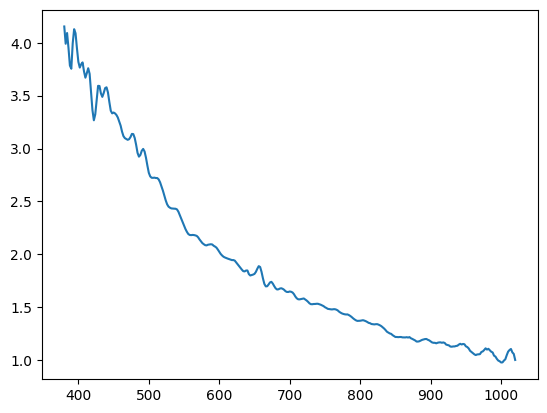

In [ ]:
import matplotlib.pyplot as plt
dust_estintion=dustest/dustest[-1]
plt.plot(starwaves,dust_estintion)

In [127]:
def Factor(filtro,dust_est,starwave):

    file_name = f"{filtro}_trasmission.txt"

    r_trasm = Table.read(file_name, format='ascii.basic')
    r_wave=r_trasm["Wavelength(A)"]
    r_value=r_trasm["Transmission(QE*Filter)"]
    
    x=starwave*10
    
    r_trasm_new=np.interp(x, r_wave, r_value)
    y_filter=r_trasm_new
    y_spectrum=np.array(dust_est)

    Num = np.trapz(y_spectrum * y_filter, x)
    Den= np.trapz(y_filter, x)
    return Num/Den           # Factor for the flux

In [158]:
lg=4500
li=8000
c=3*10**(18)
lr=6500

x_trasl_r=Factor('R',dust_estintion,starwaves)
r=x_trasl_r*lr**2/c
x_trasl_g=Factor('G',dust_estintion,starwaves)
g=x_trasl_g*lg**2/c
x_trasl_i=Factor('I',dust_estintion,starwaves)
i=x_trasl_i*li**2/c
mr=-2.5*np.log10(r)-48.6
mg=-2.5*np.log10(g)-48.6
mi=-2.5*np.log10(i)-48.6
rg=mg-mr
gi=mi-mg